In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [80]:
california = fetch_california_housing()


In [81]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['target'] = california.target
print(df)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  target  
0        -12

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [83]:
data = torch.from_numpy(df.values).float()

x_init = data[:, :-1]
y_init = data[:, -1:]

print(x_init.size(), y_init.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [84]:
# Train, Val, Test ratio
ratios = [.6, .2, .2]

In [85]:
data.size(0) * ratios[0]

12384.0

In [86]:
# 샘플 개수 출력
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples."% (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


# 랜덤 셔플링

In [87]:
# Shuffles before split
indices = torch.randperm(data.size(0))
x = torch.index_select(x_init, dim=0, index = indices)
y = torch.index_select(y_init, dim = 0, index = indices)

x = list(x.split(cnts, dim = 0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


# 데이터 정규화

In [88]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # 반드시 학습 데이터만 fitting 할 것

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

In [89]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1))
)

optimizer = optim.Adam(model.parameters())

In [90]:
n_epochs = 4000
batch_size = 256
print_interval = 100

* 최저 val loss를 추적하기 위한 변수 lowest_loss및 최저 검증 손실 값을 뱉은 모델을 저장하기 위한 변수 best_model을 생성
* best_model은 deepcopy를 해야함

# 학습 조기 종료를 위한 셋팅값
* lowest_epoch 선언

In [91]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

# 검증 작업
* 역전파로 학습을 수행하지 않음
* gradient를 계산 불필요 -> torch.no_grad 호울, with 내부에서 검증 작업 진행
* gradient 계산 위한 배후 작업 없어 계산 오버헤드가 줄어들어 속도가 빨라짐, 메모리 사용량 줄어듦

1. split으로 미니배치 크기로 나눔
2. shuffling 빠짐
3. feed-forward만 있고 backward 없음

In [92]:
y_[0].shape

torch.Size([256, 1])

In [93]:
'''train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before minibatch split
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim = 0, index = indices)
    y_ = torch.index_select(y[0], dim = 0, index=indices)


    x_ = x_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0)


    train_loss, val_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += float(loss)

    train_loss =train_loss/len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim = 0)
        y_ = y[1].split(batch_size, dim = 0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(x_i, y_i)

            val_loss += loss

            y_hat = [y_hat_i]

    valid_loss = valid_loss / len(x_)

    # Log each loss to plot after training is done
    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss%.4e valid_loss=%.4e lowest_loss = %.4e'%(
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))'''

"train_history, valid_history = [], []\n\nfor i in range(n_epochs):\n    # Shuffle before minibatch split\n    indices = torch.randperm(x[0].size(0))\n    x_ = torch.index_select(x[0], dim = 0, index = indices)\n    y_ = torch.index_select(y[0], dim = 0, index=indices)\n\n\n    x_ = x_.split(batch_size, dim = 0)\n    y_ = y_.split(batch_size, dim = 0)\n\n\n    train_loss, val_loss = 0, 0\n    y_hat = []\n\n    for x_i, y_i in zip(x_, y_):\n        y_hat_i = model(x_i)\n        loss = F.mse_loss(y_hat_i, y_i)\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        train_loss += float(loss)\n\n    train_loss =train_loss/len(x_)\n\n    with torch.no_grad():\n        x_ = x[1].split(batch_size, dim = 0)\n        y_ = y[1].split(batch_size, dim = 0)\n\n        valid_loss = 0\n\n        for x_i, y_i in zip(x_, y_):\n            y_hat_i = model(x_i)\n            loss = F.mse_loss(x_i, y_i)\n\n            val_loss += loss\n\n            y_hat = [y_hat_i]\n\

In [94]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)

    train_loss = train_loss / len(x_)    
    # You need to declare to PYTORCH to stop build the computation graph.
    with torch.no_grad():
        # You don't need to shuffle the validation set.
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    # Log each loss to plot after training is done.
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # 'state_dict()' returns model weights as key-value.
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)        
    

Epoch 100: train loss=3.5130e-01  valid_loss=3.6238e-01  lowest_loss=3.6229e-01
Epoch 200: train loss=3.3996e-01  valid_loss=3.5199e-01  lowest_loss=3.5221e-01
Epoch 300: train loss=3.3317e-01  valid_loss=3.4603e-01  lowest_loss=3.4554e-01
Epoch 400: train loss=3.3136e-01  valid_loss=3.4458e-01  lowest_loss=3.4422e-01
Epoch 500: train loss=3.3144e-01  valid_loss=3.4413e-01  lowest_loss=3.4349e-01
Epoch 600: train loss=3.2695e-01  valid_loss=3.4301e-01  lowest_loss=3.4167e-01
Epoch 700: train loss=3.1823e-01  valid_loss=3.3414e-01  lowest_loss=3.3462e-01
Epoch 800: train loss=3.1589e-01  valid_loss=3.3009e-01  lowest_loss=3.2614e-01
Epoch 900: train loss=3.0981e-01  valid_loss=3.2298e-01  lowest_loss=3.2090e-01
Epoch 1000: train loss=3.0585e-01  valid_loss=3.1901e-01  lowest_loss=3.1681e-01
Epoch 1100: train loss=3.0495e-01  valid_loss=3.1756e-01  lowest_loss=3.1574e-01
Epoch 1200: train loss=3.0718e-01  valid_loss=3.1591e-01  lowest_loss=3.1399e-01
Epoch 1300: train loss=3.0531e-01  va

<All keys matched successfully>

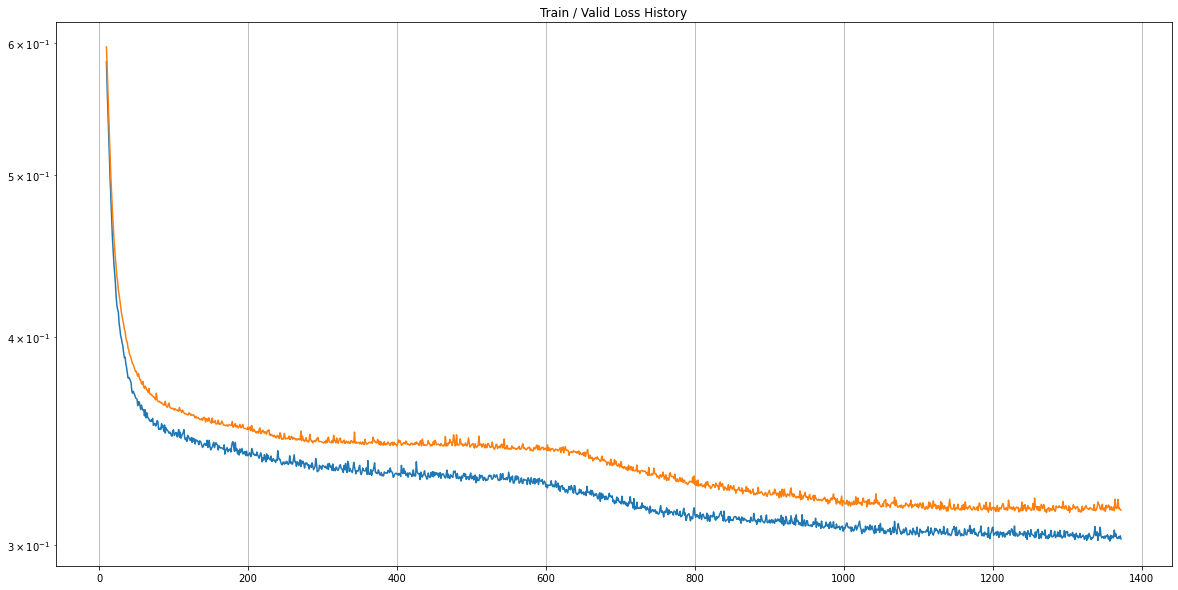

In [95]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()